            ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0      0x2318    COIMBRES13DEL01                  23                   12.54    
1      0x3474     BANGRES15DEL01                   28                     4.6   
2      0x9420      JAPRES09DEL03                   23                     4.5   
3      0x72ee      JAPRES07DEL03                   21                     4.8   
4      0xa759     CHENRES19DEL01                   31                     4.6   
...        ...                ...                 ...                     ...   
11394  0x6909      JAPRES01DEL01                   35                     4.6   
11395  0x443b      JAPRES11DEL01                   33                     4.9   
11396  0x1ea5      SURRES11DEL03                 NaN                     NaN    
11397  0x22d4      VADRES03DEL02                   27                     4.7   
11398  0xb7be     CHENRES07DEL02                   39                       5   

       Restaurant_latitude 

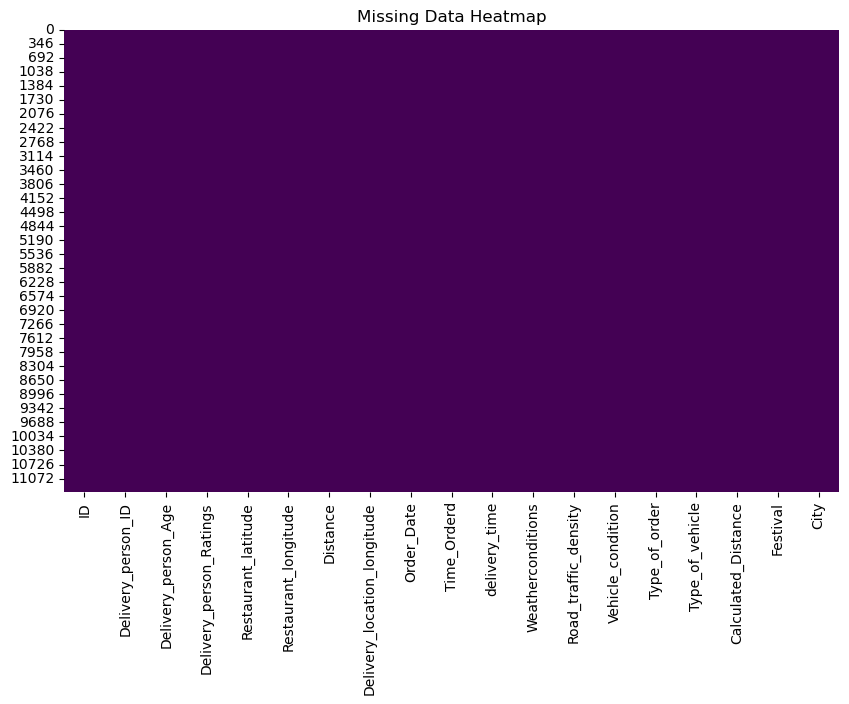


Linear Regression Model Evaluation:
MSE: 80845.96
R²: 0.20
MAE: 186.29


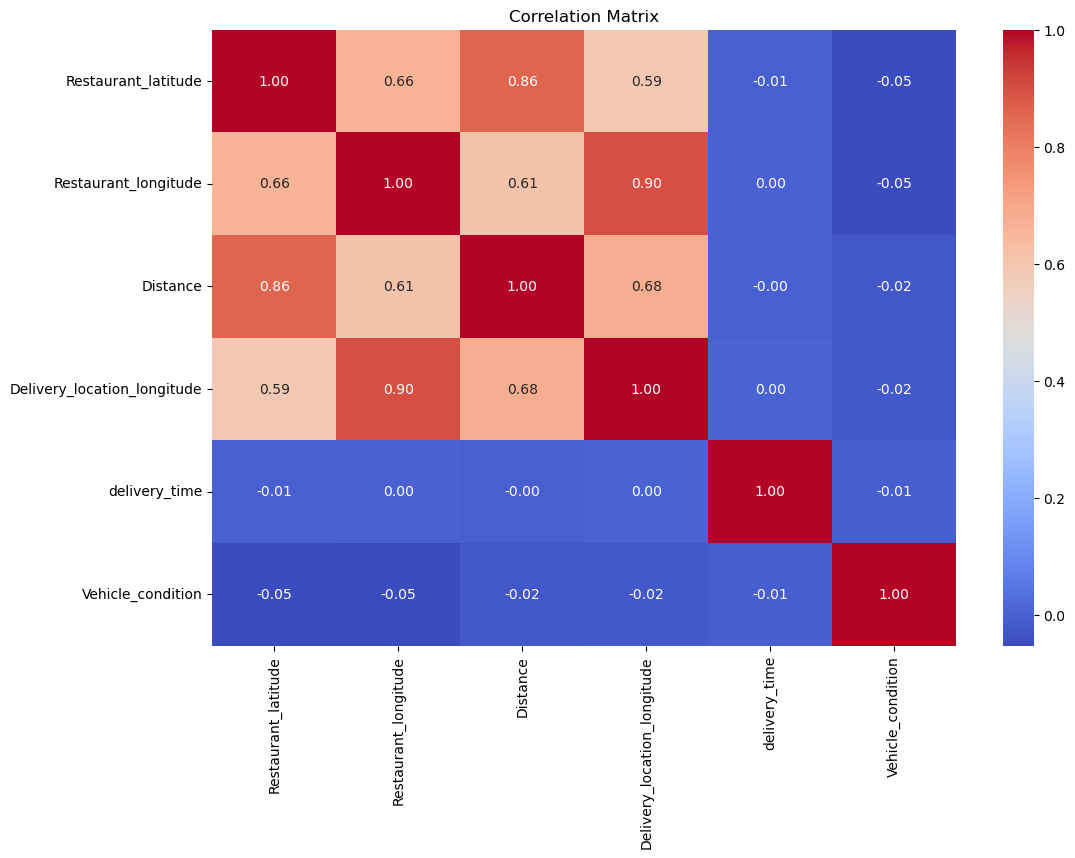

🚫 No data available for logistic regression after dropping missing values.


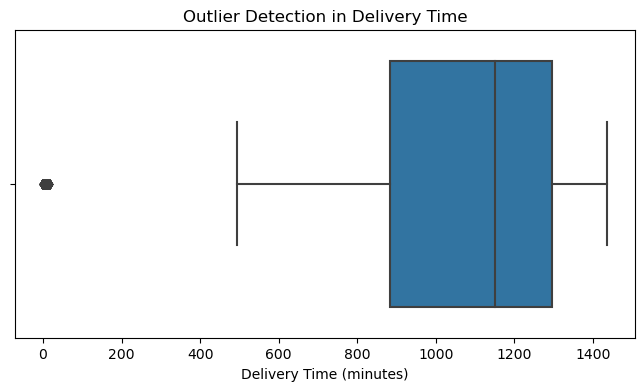


Column: Traffic
Unique values: [nan]
Missing values: 11399

Column: Weather
Unique values: [nan]
Missing values: 11399
Dropping column 'Traffic' because it contains only missing values.
Dropping column 'Weather' because it contains only missing values.


In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# Load the dataset
data = pd.read_csv('Food_Delivery_Time_Prediction.csv')
data.columns = data.columns.str.strip()  # Remove extra spaces in column names
data.head()
print(data)

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

# Handle missing values and convert distance
if 'Distance' in data.columns:
    data['Distance'] = pd.to_numeric(data['Distance'], errors='coerce')
    data['Distance'].fillna(data['Distance'].median(), inplace=True)

# Clean categorical values
for col in ['Road_traffic_density', 'Type_of_order']:
    if col in data.columns:
        data[col] = data[col].str.strip()

# Convert delivery_time to minutes (numeric)
def convert_time_to_minutes(time_str):
    try:
        h, m, s = map(int, time_str.strip().split(':'))
        return h * 60 + m + s / 60
    except:
        return np.nan

if 'delivery_time' in data.columns:
    data['delivery_time'] = data['delivery_time'].apply(convert_time_to_minutes)
    data.dropna(subset=['delivery_time'], inplace=True)

# One-Hot Encoding for categorical features
X = data[['Distance', 'Road_traffic_density', 'Type_of_order']].copy()
X = pd.get_dummies(X, columns=['Road_traffic_density', 'Type_of_order'], drop_first=True)
y = data['delivery_time']

# Train/test split for regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

# Linear model evaluation
print("\nLinear Regression Model Evaluation:")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")

# EDA - Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


# Add binary delivery status column for classification (e.g. fast if under 30 mins)
threshold = 30
data['Delivery_Status'] = data['delivery_time'].apply(lambda x: 1 if x < threshold else 0)


# Build logistic regression dataset
# Ensure required columns exist
for col in ['Traffic', 'Weather', 'Delivery_Person_Age']:
    if col not in data.columns:
        data[col] = np.nan

# Drop rows with missing target or any of the important features
required_cols = ['Traffic', 'Weather', 'Delivery_Person_Age', 'Delivery_Status']
data_log = data.dropna(subset=required_cols).copy()

# Check if any data is left after dropping missing values
if data_log.empty:
    print("🚫 No data available for logistic regression after dropping missing values.")
else:
    # Encode categorical features
    categorical_cols = ['Traffic', 'Weather']
    data_log = pd.get_dummies(data_log, columns=categorical_cols, drop_first=True)

    # Define features and target
    X_logistic = data_log.drop(columns=['Delivery_Status'])
    y_logistic = data_log['Delivery_Status']

    # Train/Test Split
    X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
        X_logistic, y_logistic, test_size=0.2, random_state=42
    )

    # Logistic Regression
    logistic_model = LogisticRegression(max_iter=1000)
    logistic_model.fit(X_train_log, y_train_log)

    # Predictions
    y_pred_log = logistic_model.predict(X_test_log)

    # Evaluation
    accuracy = accuracy_score(y_test_log, y_pred_log)
    precision = precision_score(y_test_log, y_pred_log)
    recall = recall_score(y_test_log, y_pred_log)
    f1 = f1_score(y_test_log, y_pred_log)
    conf_matrix = confusion_matrix(y_test_log, y_pred_log)
    
   


    # Print results
    print("\n✅ Logistic Regression Model Evaluation:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:\n", conf_matrix)

    # Actionable insights
    print("\nActionable Insights:")
    if accuracy < 0.8:
        print("- Consider optimizing delivery routes.")
    if recall < 0.7:
        print("- Improve training during high-traffic periods.")

# Haversine calculation for distance if coordinates exist
def haversine(lat1, lon1, lat2, lon2):
    from math import radians, cos, sin, asin, sqrt
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in km
    return c * r

required_coords = ['Customer_Lat', 'Customer_Lon', 'Restaurant_Lat', 'Restaurant_Lon']
if all(col in data.columns for col in required_coords):
    data.dropna(subset=required_coords, inplace=True)
    data['Calculated_Distance'] = data.apply(
        lambda row: haversine(row['Customer_Lat'], row['Customer_Lon'],
                              row['Restaurant_Lat'], row['Restaurant_Lon']), axis=1
    )
    print("\nCalculated Haversine Distance Preview:")
    print(data[['Calculated_Distance']].head())

# Rush hour feature engineering
if 'Delivery_sTime' in data.columns:
    data['Delivery_sTime'] = pd.to_datetime(data['Delivery_sTime'], errors='coerce')
    data.dropna(subset=['Delivery_sTime'], inplace=True)
    data['Rush_Hour'] = data['Delivery_sTime'].dt.hour.apply(lambda h: 1 if 17 <= h < 19 else 0)

# Outlier Detection (boxplot)
plt.figure(figsize=(8, 4))
sns.boxplot(x=data['delivery_time'])
plt.title('Outlier Detection in Delivery Time')
plt.xlabel('Delivery Time (minutes)')
plt.show()

for col in ['Traffic', 'Weather']:
    print(f"\nColumn: {col}")
    print("Unique values:", data[col].unique())
    print("Missing values:", data[col].isnull().sum())
for col in ['Traffic', 'Weather']:
    if data[col].isnull().all():
        print(f"Dropping column '{col}' because it contains only missing values.")
        data.drop(columns=[col], inplace=True)


